# Задание 12

В этой задаче вам необходимо восстановить поле, которое образуется в результате продувки в аэродинамической трубе.
Вам задан набор данных `train.csv`, состоящий из следующих полей:

`x`, `y`, `z` — координаты точки в пространстве

`uz`, `uy`, `uz` — вектор скорости потока в данной точке

`p` — давление в данной точке

Набор данных test.csv содержит только координаты `(x, y, z)`.

Вам необходимо послать в тестирующую систему файл `submission.csv`, `k`-я строка которого будет содержать предсказанные значения 
`ux`, `uy`, `uz`, `p` для `k`-ой строки файла `test.csv`. Предсказанные таргеты в каждой строке разделяются запятыми. Нулевая строка должна содержать название колонок (игнорируются при чтении).

После корректировки условия, метрика: 
$$
\frac{10}{4} * (min(1, max(0, \frac{1.9 - MAE_{u_x}}{1.9 - 1.1})) + min(1, max(0, \frac{1.9 - MAE_{u_y}}{1.9 - 1.1})) + min(1, max(0, \frac{1.9 - MAE_{u_z}}{1.9 - 1.1})) + min(1, max(0, \frac{1900 - MAE_p}{1900 - 500})))
$$

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

train_name = 'train.csv'
test_name = 'test.csv'
sample_name = 'sample_submission.csv'
submission_name = 'submission.csv'

# Hide GPU from TensorFlow
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

data_path = os.path.join('/tf','shared_data','profi-23', '12') + os.path.sep
train_path = data_path + train_name
test_path = data_path + test_name
sample_path = data_path + sample_name
submission_path = data_path + submission_name

In [2]:
train_csv = pd.read_csv(train_path)
test_csv = pd.read_csv(test_path)
train_csv

,x,y,z,u_x,u_y,u_z,p
0,-2.182809,-0.029668,-4.177883,410.436506,0.013901,-0.054928,100030.436265
1,-5.697199,-1.168055,2.704167,410.437352,-0.030757,0.021365,100020.971632
2,-2.388080,0.489320,-4.422072,410.443844,0.028441,-0.042093,100021.156537
3,-6.859628,0.177311,-1.745587,410.430337,0.008494,-0.011427,100018.526121
4,2.668538,-0.702350,3.033114,417.831936,-0.717926,0.116151,97710.352064
...,...,...,...,...,...,...,...
8527,-4.240097,-0.190458,-0.233550,406.192347,19.419476,-7.903454,102458.496025
8528,-2.490715,-0.443627,-3.005777,410.190644,-0.012390,-0.552977,100225.470127
8529,1.819966,-0.805841,-4.031370,409.337590,-0.234673,-1.674802,100720.371138
8530,-1.464362,-1.064565,3.252417,410.305496,-0.110896,0.647835,100233.838109


In [3]:
test_csv

,x,y,z
0,12.595389,-0.676479,9.448017
1,-5.115985,0.332546,-1.952567
2,-2.182809,-0.133158,4.463463
3,2.233563,-0.857583,-3.054615
4,-0.847552,-0.185422,-1.177141
...,...,...,...
3651,-2.695986,-0.598862,-3.103453
3652,12.134517,-0.883459,-7.321329
3653,-3.927776,-1.165944,0.220514
3654,1.306790,-0.909331,3.745842


In [4]:
feat_cols = ['x', 'y', 'z']
target_cols = ['u_x', 'u_y', 'u_z', 'p']

n_feats = len(feat_cols)
n_targets = len(target_cols)

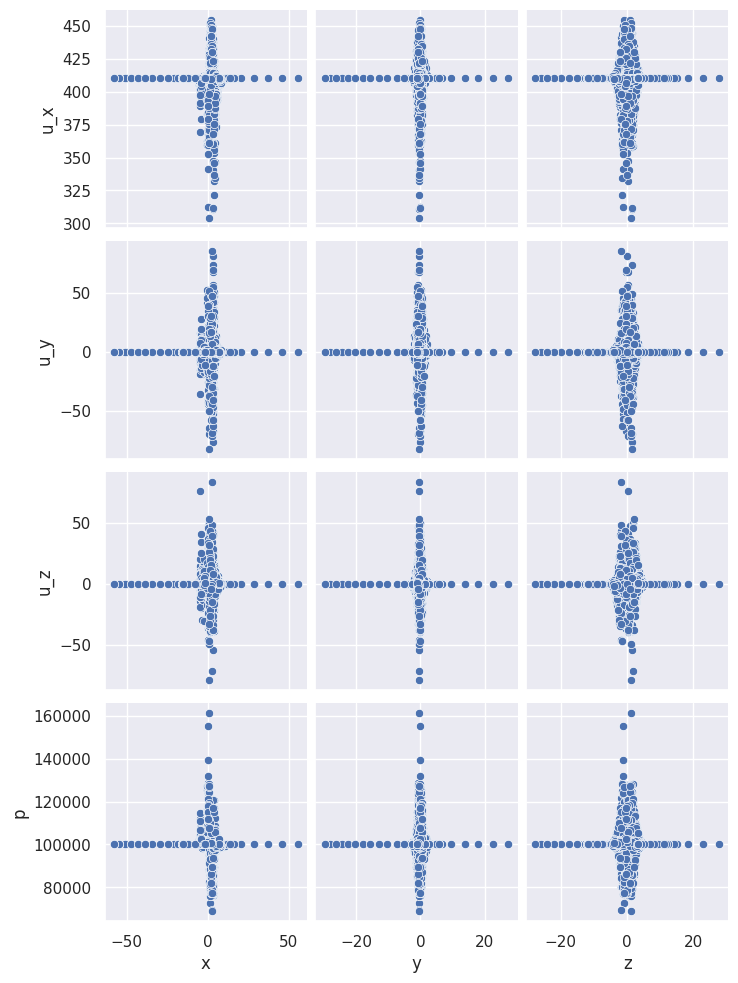

In [5]:
sns.pairplot(train_csv, x_vars=feat_cols, y_vars=target_cols)

In [6]:
import tensorflow as tf

2023-11-30 18:47:39.274538: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 18:47:39.274563: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 18:47:39.274580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 18:47:39.279380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def generate_train_data():
    mean, std = train_csv[target_cols].mean(), train_csv[target_cols].std()
    for (i, data) in train_csv.iterrows():
        yield (data[feat_cols], (data[target_cols] - mean) / std)


def prep_train_data():
    return tf.data.Dataset.from_generator(
        generate_train_data, 
        output_signature=(
            tf.TensorSpec(shape=(n_feats), dtype=tf.float32), 
            tf.TensorSpec(shape=(n_targets), dtype=tf.float32)
        )
    )

In [8]:
from tensorflow.keras import layers, losses, metrics, regularizers, Sequential

def prep_linear(inputs, outputs, layer_sizes, use_dropout=False, use_regularizers=False):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(inputs)))
    
    for layer_size in layer_sizes:
        if use_regularizers:
            model.add(layers.Dense(layer_size, kernel_regularizer=regularizers.L2(1e-4)))
        else:
            model.add(layers.Dense(layer_size))
        model.add(layers.PReLU()) # PReLU > LeakyReLU
        if use_dropout:
            model.add(layers.Dropout(.25))
    
    model.add(layers.Dense(outputs))
    return model


def prep_unet(inputs, outputs, layer_sizes):
    inputs = tf.keras.Input((inputs))
    x = inputs

    skips = []

    for layer_size in layer_sizes:
        x = layers.Dense(layer_size)(x)
        x = layers.PReLU()(x) # PReLU > LeakyReLU
        skips.append(x)

    for layer_size, skip in zip(layer_sizes[-2::-1], skips[-2::-1]):
        x = layers.Dense(layer_size)(x)
        x = layers.PReLU()(x) # PReLU > LeakyReLU
        x = tf.keras.layers.concatenate([x, skip])

    model = tf.keras.Model(inputs, layers.Dense(outputs)(x))
    return model

In [9]:
def build_regression(model):
    model.compile(
        optimizer='adam', 
        loss=losses.MeanAbsoluteError(),
        metrics=[metrics.RootMeanSquaredError(name='rmse')]
    )


def prep_simple():
    dense_model = prep_linear(n_feats, n_targets, [32 * n_feats, 64 * n_feats, 16 * n_feats], use_dropout=True)
    build_regression(dense_model)
    return dense_model
    

def prep_parallel():
    inputs = tf.keras.Input((n_feats))
    
    speed_model = prep_linear(n_feats, n_targets - 1, [32 * n_feats, 64 * n_feats, 16 * n_feats], use_dropout=True, use_regularizers=True)
    pressure_model = prep_linear(n_feats, 1, [16 * n_feats, 32 * n_feats, 8 * n_feats], use_dropout=True, use_regularizers=False)

    outputs = layers.concatenate([speed_model(inputs), pressure_model(inputs)])
    parallel_model = tf.keras.Model(inputs, outputs)

    build_regression(parallel_model)
    
    return parallel_model


def prep_parallel_unet():
    inputs = tf.keras.Input((n_feats))
    
    speed_model = prep_unet(n_feats, n_targets - 1, [8 * n_feats, 16 * n_feats, 32 * n_feats])
    pressure_model = prep_unet(n_feats, 1, [4 * n_feats, 8 * n_feats, 16 * n_feats])

    outputs = layers.concatenate([speed_model(inputs), pressure_model(inputs)])
    parallel_model = tf.keras.Model(inputs, outputs)

    build_regression(parallel_model)
    
    return parallel_model

In [10]:
from tensorflow.keras.utils import plot_model

model = prep_parallel_unet()
plot_model(model, '12.png', show_shapes=True, expand_nested=True)
model.summary()

2023-11-30 18:47:40.576389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 18:47:40.582923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 18:47:40.583133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 model (Functional)          (None, 3)                    13371     ['input_1[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 1)                    3469      ['input_1[0][0]']             
                                                                                                  
 concatenate_4 (Concatenate  (None, 4)                    0         ['model[0][0]',               
 )                                                                   'model_1[0][0]']       

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 2000
VAL_SIZE = len(train_csv.index) // 7

ds = prep_train_data()

train_ds = ds.skip(VAL_SIZE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds.take(VAL_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

training_folder = os.path.join('dnn', '12')
tensoboard_path = os.path.join(training_folder, 'logs')
model_path = os.path.join(training_folder, 'best')

model_callbacks = [
    EarlyStopping(patience=10),
    TensorBoard(log_dir=tensoboard_path),
    ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [13]:
%load_ext tensorboard

%tensorboard --logdir $tensoboard_path --host 0.0.0.0

In [20]:
model.fit(train_ds, validation_data=val_ds, epochs=120, callbacks=model_callbacks)

Epoch 1/120
115/115 [==============================] - 12s 53ms/step - loss: 0.1221 - rmse: 0.4114 - val_loss: 0.1217 - val_rmse: 0.3838
Epoch 2/120
115/115 [==============================] - 10s 62ms/step - loss: 0.1186 - rmse: 0.4043 - val_loss: 0.1260 - val_rmse: 0.3885
Epoch 3/120
115/115 [==============================] - 9s 54ms/step - loss: 0.1192 - rmse: 0.4056 - val_loss: 0.1260 - val_rmse: 0.3728
Epoch 4/120
115/115 [==============================] - 10s 63ms/step - loss: 0.1181 - rmse: 0.4033 - val_loss: 0.1251 - val_rmse: 0.3727
Epoch 5/120
115/115 [==============================] - 10s 62ms/step - loss: 0.1179 - rmse: 0.4011 - val_loss: 0.1188 - val_rmse: 0.3773
Epoch 6/120
115/115 [==============================] - 10s 58ms/step - loss: 0.1167 - rmse: 0.3996 - val_loss: 0.1202 - val_rmse: 0.3614
Epoch 7/120
112/115 [============================>.] - ETA: 0s - loss: 0.1161 - rmse: 0.4023INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 10s 70ms/step - loss: 0.1158 - rmse: 0.4000 - val_loss: 0.1154 - val_rmse: 0.3695
Epoch 8/120
115/115 [==============================] - 9s 60ms/step - loss: 0.1157 - rmse: 0.3937 - val_loss: 0.1241 - val_rmse: 0.3812
Epoch 9/120
115/115 [==============================] - 9s 50ms/step - loss: 0.1169 - rmse: 0.3995 - val_loss: 0.1180 - val_rmse: 0.3726
Epoch 10/120
115/115 [==============================] - 10s 60ms/step - loss: 0.1164 - rmse: 0.3964 - val_loss: 0.1266 - val_rmse: 0.3765
Epoch 11/120
115/115 [==============================] - 10s 60ms/step - loss: 0.1154 - rmse: 0.3940 - val_loss: 0.1221 - val_rmse: 0.3745
Epoch 12/120
115/115 [==============================] - 10s 60ms/step - loss: 0.1122 - rmse: 0.3916 - val_loss: 0.1163 - val_rmse: 0.3693
Epoch 13/120
115/115 [==============================] - 9s 55ms/step - loss: 0.1138 - rmse: 0.3898 - val_loss: 0.1201 - val_rmse: 0.3616
Epoch 14/120
115/115 [==============================

INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 11s 72ms/step - loss: 0.1120 - rmse: 0.3882 - val_loss: 0.1145 - val_rmse: 0.3627
Epoch 16/120
115/115 [==============================] - 10s 64ms/step - loss: 0.1141 - rmse: 0.3890 - val_loss: 0.1174 - val_rmse: 0.3580
Epoch 17/120
115/115 [==============================] - 10s 61ms/step - loss: 0.1131 - rmse: 0.3894 - val_loss: 0.1246 - val_rmse: 0.3809
Epoch 18/120
112/115 [============================>.] - ETA: 0s - loss: 0.1116 - rmse: 0.3814INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 11s 74ms/step - loss: 0.1121 - rmse: 0.3863 - val_loss: 0.1132 - val_rmse: 0.3551
Epoch 19/120
115/115 [==============================] - 9s 54ms/step - loss: 0.1113 - rmse: 0.3861 - val_loss: 0.1204 - val_rmse: 0.3740
Epoch 20/120
115/115 [==============================] - 9s 60ms/step - loss: 0.1123 - rmse: 0.3852 - val_loss: 0.1150 - val_rmse: 0.3569
Epoch 21/120
115/115 [==============================] - 10s 57ms/step - loss: 0.1136 - rmse: 0.3883 - val_loss: 0.1150 - val_rmse: 0.3707
Epoch 22/120
115/115 [==============================] - ETA: 0s - loss: 0.1101 - rmse: 0.3834INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 11s 72ms/step - loss: 0.1101 - rmse: 0.3834 - val_loss: 0.1108 - val_rmse: 0.3554
Epoch 23/120
115/115 [==============================] - 9s 61ms/step - loss: 0.1125 - rmse: 0.3860 - val_loss: 0.1130 - val_rmse: 0.3560
Epoch 24/120
115/115 [==============================] - 9s 57ms/step - loss: 0.1100 - rmse: 0.3745 - val_loss: 0.1198 - val_rmse: 0.3724
Epoch 25/120
115/115 [==============================] - 9s 59ms/step - loss: 0.1104 - rmse: 0.3821 - val_loss: 0.1165 - val_rmse: 0.3606
Epoch 26/120
115/115 [==============================] - 10s 61ms/step - loss: 0.1091 - rmse: 0.3796 - val_loss: 0.1168 - val_rmse: 0.3711
Epoch 27/120
115/115 [==============================] - 9s 57ms/step - loss: 0.1088 - rmse: 0.3805 - val_loss: 0.1183 - val_rmse: 0.3741
Epoch 28/120
115/115 [==============================] - 9s 57ms/step - loss: 0.1100 - rmse: 0.3802 - val_loss: 0.1150 - val_rmse: 0.3452
Epoch 29/120
115/115 [==============================

INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 12s 77ms/step - loss: 0.1086 - rmse: 0.3770 - val_loss: 0.1105 - val_rmse: 0.3557
Epoch 31/120
115/115 [==============================] - 9s 61ms/step - loss: 0.1081 - rmse: 0.3755 - val_loss: 0.1159 - val_rmse: 0.3543
Epoch 32/120
115/115 [==============================] - 10s 61ms/step - loss: 0.1070 - rmse: 0.3724 - val_loss: 0.1141 - val_rmse: 0.3568
Epoch 33/120
115/115 [==============================] - 10s 63ms/step - loss: 0.1074 - rmse: 0.3730 - val_loss: 0.1112 - val_rmse: 0.3491
Epoch 34/120
115/115 [==============================] - 9s 58ms/step - loss: 0.1089 - rmse: 0.3744 - val_loss: 0.1154 - val_rmse: 0.3595
Epoch 35/120
115/115 [==============================] - 10s 65ms/step - loss: 0.1083 - rmse: 0.3766 - val_loss: 0.1132 - val_rmse: 0.3602
Epoch 36/120
115/115 [==============================] - 9s 56ms/step - loss: 0.1061 - rmse: 0.3698 - val_loss: 0.1128 - val_rmse: 0.3664
Epoch 37/120
115/115 [============================

INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 11s 73ms/step - loss: 0.1069 - rmse: 0.3693 - val_loss: 0.1093 - val_rmse: 0.3438
Epoch 41/120
115/115 [==============================] - 9s 56ms/step - loss: 0.1044 - rmse: 0.3641 - val_loss: 0.1146 - val_rmse: 0.3482
Epoch 42/120
115/115 [==============================] - 9s 55ms/step - loss: 0.1048 - rmse: 0.3662 - val_loss: 0.1099 - val_rmse: 0.3386
Epoch 43/120
115/115 [==============================] - 10s 56ms/step - loss: 0.1055 - rmse: 0.3690 - val_loss: 0.1123 - val_rmse: 0.3553
Epoch 44/120
113/115 [============================>.] - ETA: 0s - loss: 0.1046 - rmse: 0.3690INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 11s 78ms/step - loss: 0.1046 - rmse: 0.3687 - val_loss: 0.1088 - val_rmse: 0.3433
Epoch 45/120
115/115 [==============================] - 9s 55ms/step - loss: 0.1049 - rmse: 0.3700 - val_loss: 0.1088 - val_rmse: 0.3508
Epoch 46/120
113/115 [============================>.] - ETA: 0s - loss: 0.1044 - rmse: 0.3611INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 11s 71ms/step - loss: 0.1048 - rmse: 0.3679 - val_loss: 0.1087 - val_rmse: 0.3446
Epoch 47/120
115/115 [==============================] - 10s 63ms/step - loss: 0.1033 - rmse: 0.3593 - val_loss: 0.1128 - val_rmse: 0.3625
Epoch 48/120
115/115 [==============================] - 9s 54ms/step - loss: 0.1040 - rmse: 0.3606 - val_loss: 0.1199 - val_rmse: 0.3606
Epoch 49/120
115/115 [==============================] - 10s 63ms/step - loss: 0.1037 - rmse: 0.3586 - val_loss: 0.1194 - val_rmse: 0.3805
Epoch 50/120
115/115 [==============================] - 10s 62ms/step - loss: 0.1052 - rmse: 0.3644 - val_loss: 0.1129 - val_rmse: 0.3621
Epoch 51/120
113/115 [============================>.] - ETA: 0s - loss: 0.1026 - rmse: 0.3616INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 11s 72ms/step - loss: 0.1027 - rmse: 0.3603 - val_loss: 0.1073 - val_rmse: 0.3458
Epoch 52/120
115/115 [==============================] - 10s 63ms/step - loss: 0.1025 - rmse: 0.3614 - val_loss: 0.1144 - val_rmse: 0.3585
Epoch 53/120
115/115 [==============================] - 9s 59ms/step - loss: 0.1025 - rmse: 0.3586 - val_loss: 0.1128 - val_rmse: 0.3375
Epoch 54/120
115/115 [==============================] - ETA: 0s - loss: 0.1027 - rmse: 0.3619INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 12s 81ms/step - loss: 0.1027 - rmse: 0.3619 - val_loss: 0.1071 - val_rmse: 0.3397
Epoch 55/120
115/115 [==============================] - ETA: 0s - loss: 0.0996 - rmse: 0.3571INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 10s 67ms/step - loss: 0.0996 - rmse: 0.3571 - val_loss: 0.1066 - val_rmse: 0.3517
Epoch 56/120
115/115 [==============================] - 9s 59ms/step - loss: 0.1024 - rmse: 0.3601 - val_loss: 0.1083 - val_rmse: 0.3495
Epoch 57/120
115/115 [==============================] - 13s 86ms/step - loss: 0.1018 - rmse: 0.3594 - val_loss: 0.1082 - val_rmse: 0.3488
Epoch 58/120
110/115 [===========================>..] - ETA: 0s - loss: 0.1001 - rmse: 0.3569INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 50s 392ms/step - loss: 0.1003 - rmse: 0.3572 - val_loss: 0.1059 - val_rmse: 0.3333
Epoch 59/120
112/115 [============================>.] - ETA: 0s - loss: 0.1000 - rmse: 0.3591INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 22s 144ms/step - loss: 0.0998 - rmse: 0.3570 - val_loss: 0.1049 - val_rmse: 0.3448
Epoch 60/120
115/115 [==============================] - 12s 69ms/step - loss: 0.1028 - rmse: 0.3598 - val_loss: 0.1083 - val_rmse: 0.3403
Epoch 61/120
115/115 [==============================] - 10s 58ms/step - loss: 0.1037 - rmse: 0.3577 - val_loss: 0.1084 - val_rmse: 0.3483
Epoch 62/120
108/115 [===========================>..] - ETA: 0s - loss: 0.0991 - rmse: 0.3556INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 11s 74ms/step - loss: 0.0993 - rmse: 0.3520 - val_loss: 0.1041 - val_rmse: 0.3255
Epoch 63/120
115/115 [==============================] - 10s 63ms/step - loss: 0.0996 - rmse: 0.3526 - val_loss: 0.1087 - val_rmse: 0.3379
Epoch 64/120
115/115 [==============================] - 9s 57ms/step - loss: 0.0982 - rmse: 0.3475 - val_loss: 0.1067 - val_rmse: 0.3569
Epoch 65/120
115/115 [==============================] - 11s 64ms/step - loss: 0.0994 - rmse: 0.3533 - val_loss: 0.1076 - val_rmse: 0.3376
Epoch 66/120
115/115 [==============================] - ETA: 0s - loss: 0.0984 - rmse: 0.3490INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 33s 263ms/step - loss: 0.0984 - rmse: 0.3490 - val_loss: 0.1031 - val_rmse: 0.3398
Epoch 67/120
115/115 [==============================] - 9s 52ms/step - loss: 0.0992 - rmse: 0.3535 - val_loss: 0.1084 - val_rmse: 0.3502
Epoch 68/120
115/115 [==============================] - 10s 57ms/step - loss: 0.1002 - rmse: 0.3514 - val_loss: 0.1079 - val_rmse: 0.3318
Epoch 69/120
115/115 [==============================] - 9s 52ms/step - loss: 0.0981 - rmse: 0.3484 - val_loss: 0.1077 - val_rmse: 0.3387
Epoch 70/120
115/115 [==============================] - 8s 48ms/step - loss: 0.0992 - rmse: 0.3495 - val_loss: 0.1041 - val_rmse: 0.3493
Epoch 71/120
115/115 [==============================] - 8s 49ms/step - loss: 0.0981 - rmse: 0.3492 - val_loss: 0.1046 - val_rmse: 0.3457
Epoch 72/120
115/115 [==============================] - 8s 48ms/step - loss: 0.0984 - rmse: 0.3506 - val_loss: 0.1032 - val_rmse: 0.3474
Epoch 73/120
115/115 [=============================

INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 10s 66ms/step - loss: 0.0980 - rmse: 0.3457 - val_loss: 0.1005 - val_rmse: 0.3363
Epoch 75/120
115/115 [==============================] - 8s 49ms/step - loss: 0.0972 - rmse: 0.3449 - val_loss: 0.1036 - val_rmse: 0.3241
Epoch 76/120
115/115 [==============================] - 8s 49ms/step - loss: 0.0986 - rmse: 0.3469 - val_loss: 0.1072 - val_rmse: 0.3473
Epoch 77/120
115/115 [==============================] - 8s 49ms/step - loss: 0.1002 - rmse: 0.3490 - val_loss: 0.1086 - val_rmse: 0.3425
Epoch 78/120
115/115 [==============================] - 9s 56ms/step - loss: 0.0973 - rmse: 0.3467 - val_loss: 0.1087 - val_rmse: 0.3412
Epoch 79/120
115/115 [==============================] - 10s 59ms/step - loss: 0.0976 - rmse: 0.3437 - val_loss: 0.1050 - val_rmse: 0.3389
Epoch 80/120
114/115 [============================>.] - ETA: 0s - loss: 0.0970 - rmse: 0.3455INFO:tensorflow:Assets written to: dnn/12/best/assets


INFO:tensorflow:Assets written to: dnn/12/best/assets


115/115 [==============================] - 12s 70ms/step - loss: 0.0970 - rmse: 0.3452 - val_loss: 0.0993 - val_rmse: 0.3245
Epoch 81/120
115/115 [==============================] - 10s 61ms/step - loss: 0.0970 - rmse: 0.3389 - val_loss: 0.1107 - val_rmse: 0.3333
Epoch 82/120
115/115 [==============================] - 10s 57ms/step - loss: 0.0960 - rmse: 0.3431 - val_loss: 0.1116 - val_rmse: 0.3571
Epoch 83/120
115/115 [==============================] - 10s 63ms/step - loss: 0.0978 - rmse: 0.3451 - val_loss: 0.1056 - val_rmse: 0.3321
Epoch 84/120
115/115 [==============================] - 10s 59ms/step - loss: 0.0965 - rmse: 0.3427 - val_loss: 0.1005 - val_rmse: 0.3314
Epoch 85/120
115/115 [==============================] - 9s 58ms/step - loss: 0.0964 - rmse: 0.3387 - val_loss: 0.1023 - val_rmse: 0.3301
Epoch 86/120
115/115 [==============================] - 9s 60ms/step - loss: 0.0967 - rmse: 0.3439 - val_loss: 0.1031 - val_rmse: 0.3374
Epoch 87/120
115/115 [===========================

In [21]:
model = tf.keras.models.load_model(model_path)

In [22]:
# Evaluate on full training data
train_metrics = model.evaluate(ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE))

134/134 [==============================] - 9s 67ms/step - loss: 0.0929 - rmse: 0.3339


2023-11-30 20:23:15.560466: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7325575383054177857
2023-11-30 20:23:15.560502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7524731584003766510
2023-11-30 20:23:15.560510: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10770088465028237548


In [23]:
def generate_test_data():
    for (i, data) in test_csv.iterrows():
        yield data[feat_cols]


def prep_test_data():
    return tf.data.Dataset.from_generator(
        generate_test_data, 
        output_signature=tf.TensorSpec(shape=(n_feats), dtype=tf.float32)
    )

In [24]:
test_ds = prep_test_data().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_outputs = model.predict(test_ds)

mean, std = train_csv[target_cols].mean(), train_csv[target_cols].std()

submission_df = pd.DataFrame(test_outputs, columns=target_cols)
submission_df = submission_df * std + mean
submission_df

58/58 [==============================] - 2s 33ms/step


2023-11-30 20:23:17.691733: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8701529722525181352


,u_x,u_y,u_z,p
0,410.411516,-0.151038,0.297176,100075.617711
1,410.362261,-0.060990,-0.028394,100050.418298
2,410.226893,-0.021849,-0.044029,100038.225306
3,412.483023,-3.231788,-6.239308,100466.766147
4,409.532989,2.354951,-4.425670,100852.765924
...,...,...,...,...
3651,410.358368,-0.122843,-0.188028,100051.215527
3652,410.226395,-0.237976,0.130129,99836.034335
3653,404.916540,-10.519151,2.924110,103952.706793
3654,410.250776,-0.113626,0.764731,100309.644926


In [25]:
submission_df.to_csv(submission_path, index=False)

## Winning model

10/10 Achieved with model trained on MAE loss for ~180 epochs with this DNN architecture:
![DNN keras plot](12.png)